# requirements

In [62]:
# !pip install stable_baselines3
# !pip install 'shimmy>=0.2.1

# Import Libraries

In [63]:
# Block 1
import gym
from gym import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from datetime import datetime
import matplotlib.pyplot as plt


# setting the class and it's methods

In [83]:

class SatelliteBandwidthEnv(gym.Env):
    def __init__(self, data, total_bandwidth=10000, cir=1000):
        super(SatelliteBandwidthEnv, self).__init__()
        self.reward_history, self.efficiency_history, self.ratio_history = [], [], []
        self.data = data
        self.num_users = 10
        self.total_bandwidth = total_bandwidth
        self.cir = cir
        self.state = np.zeros((self.num_users, 7))
        self.time_step = 0

        # Variables to calculate the average efficiency
        self.R_efficiency_avg=0
        self.N=0
        # Variables to calculate the ratio
        self.ratio=0
        self.M=0

        # Penalty coefficients
        self.penalty_coefficient_over = 3
        self.penalty_coefficient_abusive = -0.5
        self.abuse_threshold = 0.2
        self.min_duration = 3
        self.adaptive_scaling_factor = 1.0

        self.abuse_counters = np.zeros(self.num_users, dtype=int)  # Track abuse counters for each user
        self.abuse_scores = np.zeros(self.num_users, dtype=int)    # Track cumulative abuse scores for each user
        self.abusive_penalty_coeff = 5  # Set a penalty coefficient for abusive usage


        # Initialize abuse counters
        self.abuse_counters = np.zeros(self.num_users)  # Abuse counters for each user

        # Define state and action spaces
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.num_users, 7), dtype=np.float32)
        self.action_space = spaces.Box(low=cir, high=total_bandwidth, shape=(self.num_users,), dtype=np.float32)

    def reset(self, time_step=0):
        # Initialize time step and state
        self.time_step = time_step
        self.state = np.zeros((self.num_users, 7))

        # Extract data for the current time step
        current_data = self.data.iloc[self.time_step * self.num_users:(self.time_step + 1) * self.num_users]

        # Set Device ID (DID) as integers
        self.state[:, 0] = current_data['DID'].astype(int).values

        # Convert 'Date' to datetime format if it's in string format
        if current_data['Date'].dtype == 'object':
            current_data['Date'] = pd.to_datetime(current_data['Date'])

        # Extract Unix timestamp directly or use hour for usage patterns
        self.state[:, 1] = current_data['Date'].apply(lambda x: x.timestamp()).values  # Unix timestamp

        # Set Bandwidth Requested
        self.state[:, 2] = current_data['BW_REQUESTED'].values

        # Initialize Bandwidth Allocated to zero
        self.state[:, 3] = self.cir

        # Set CIR for all users
        self.state[:, 4] = self.cir

        # Initialize MIR to CIR initially
        self.state[:, 5] = self.cir

        # Initialize Abuse Usage Indicator to zero
        self.state[:, 6] = 0

        return self.state

    def step(self, action):
        # Calculate reward, efficiency, and ratio as before
        reward = self.calculate_reward()
        efficiency = self.R_efficiency_avg / self.N if self.N > 0 else 0
        ratio = self.ratio / (self.time_step * self.num_users) if self.time_step > 0 else 0

        # Store metrics
        self.reward_history.append(reward)
        self.efficiency_history.append(efficiency)
        self.ratio_history.append(ratio)

        # Extract data for the new time step
        current_data = self.data.iloc[self.time_step * self.num_users:(self.time_step + 1) * self.num_users]

        # Update state with new time slice
        self.state[:, 0] = current_data['DID'].astype(int).values

        # Convert 'Date' to datetime format if it's in string format
        if current_data['Date'].dtype == 'object':
            current_data['Date'] = pd.to_datetime(current_data['Date'])
        # Extract Unix timestamp directly or use hour for usage patterns
        self.state[:, 1] = current_data['Date'].apply(lambda x: x.timestamp()).values  # Unix timestamp

        self.state[:, 2] = current_data['BW_REQUESTED'].values

        # Initialize CIR and MIR as before, if needed
        self.state[:, 3] = np.minimum(self.state[:, 2], self.cir)  # Initial allocation with CIR
        self.state[:, 4] = self.cir  # CIR for all users
        self.state[:, 5] = self.cir  # Initial MIR
        self.state[:, 6] = 0  # Reset Abusive Usage Indicator if necessary

        # Phase 1: Initial Allocation (Ensure Minimum Bandwidth - CIR)
        initial_allocations = np.zeros(self.num_users)

        # Allocate CIR or requested bandwidth if less than CIR
        for i in range(self.num_users):
            requested_bw = self.state[i, 2]  # Bandwidth Requested
            initial_allocations[i] = min(requested_bw, self.state[i, 4])  # CIR in self.state[:, 4]

        # Update the allocated bandwidth in the state (Phase 1 allocations)
        self.state[:, 3] = initial_allocations  # Bandwidth Allocated after Phase 1

        # Calculate remaining bandwidth after CIR allocation
        remaining_bandwidth = self.total_bandwidth - np.sum(initial_allocations)

        # Phase 2: RL Agent Optimizes Remaining Bandwidth by Adjusting MIR
        # Clip the action to be within CIR and the remaining bandwidth limits
        mir_adjustments = np.clip(action, self.state[:, 4], remaining_bandwidth * self.adaptive_scaling_factor)

        # Scale down MIRs if their sum exceeds the remaining bandwidth
        if np.sum(mir_adjustments) > remaining_bandwidth:
            mir_adjustments *= remaining_bandwidth / np.sum(mir_adjustments)

        # Update MIR in the state after RL agent’s action
        self.state[:, 5] = mir_adjustments  # MIR after RL adjustment

        # Final allocation after RL agent's adjustments
        for i in range(self.num_users):
            additional_alloc = min(self.state[i, 2] - initial_allocations[i], mir_adjustments[i] - initial_allocations[i])
            self.state[i, 3] = initial_allocations[i] + max(0, additional_alloc)

        # Ensure total allocation does not exceed 10,000 Kbps
        total_allocated = np.sum(self.state[:, 3])
        if total_allocated > self.total_bandwidth:
            scaling_factor = self.total_bandwidth / total_allocated
            self.state[:, 3] *= scaling_factor

        # Update adaptive scaling factor based on total allocated bandwidth
        total_allocated = np.sum(self.state[:, 3])
        if total_allocated > self.total_bandwidth:
            # Update scaling factor to avoid over-allocation
            self.adaptive_scaling_factor = self.total_bandwidth / total_allocated
            self.state[:, 3] *= self.adaptive_scaling_factor  # Apply scaling to allocated bandwidth
        else:
            self.adaptive_scaling_factor = 1.0  # Reset if within limits

        # **Abusive Usage Detection and Management** (Insert this section)

        # 1. Update Abusive Usage Indicator
        for i in range(self.num_users):
            if self.state[i, 2] > self.state[i, 5] * (1 + self.abuse_threshold):  # Abuse condition
                self.abuse_counters[i] += 1  # Increment abuse counter
            else:
                self.abuse_counters[i] = 0  # Reset abuse counter if condition not met

        # 2. Check if abusive episode occurred for any user
        for i in range(self.num_users):
            if self.abuse_counters[i] >= self.min_duration:
                abuse_duration = self.abuse_counters[i] - self.min_duration
                self.abuse_scores[i] += abuse_duration  # Update abuse score for that user

        # 3. Calculate total abuse score across all users
        total_abuse_score = np.sum(self.abuse_scores)

        # 4. If total abuse score is 0, ensure no penalties
        if total_abuse_score == 0:
            abuse_penalty = 0  # No penalties if there's no abuse
        else:
            # Calculate abuse penalty proportional to abuse score
            abuse_penalty = self.abusive_penalty_coeff * (total_abuse_score / (self.num_users * self.time_step))

        # 5. Dynamically adjust MIR based on abuse score
        for i in range(self.num_users):
            if self.abuse_scores[i] > 0:  # If abusive behavior detected, reduce MIR
                mir_adjustments[i] *= 0.8  # Apply a 20% reduction (or any proportional factor)

        # Reassign updated MIRs back to the state
        self.state[:, 5] = mir_adjustments

        # Calculate the reward and update time step
        reward = self.calculate_reward()
        self.ratio += self.calculate_ratio()
        self.time_step += 1
        done = self.time_step >= (len(self.data) // self.num_users)

        return self.state, reward, done, {}

    def calculate_ratio(self):
            """Calculates the ratio at each time step."""
            ratio_scores = []

            for i in range(self.num_users):
                requested_bandwidth = self.state[i, 2]  # BW requested
                mir = self.state[i, 5]  # MIR

                if requested_bandwidth >= mir:
                    ratioN = mir / requested_bandwidth if requested_bandwidth > 0 else 0
                else:
                    ratioN = 1  # Full satisfaction
                # print('first : ',ratioN)
                ratio_scores.append(ratioN)

            ratioN = np.sum(ratio_scores)
            # print('Sum : ',ratioN)
            return ratioN

    def calculate_reward(self):
            """Calculates the total reward at each time step."""
            R_efficiency = self.calculate_efficiency_reward()
            P_over = self.calculate_over_allocation_penalty()
            P_abusive = self.calculate_abusive_usage_penalty(288)

            # Calculate Average Efficiency
            self.R_efficiency_avg += R_efficiency
            self.N += 1

            # Total reward calculation
            R_total = R_efficiency - P_over - P_abusive
            return R_total

    def calculate_efficiency_reward(self):
            """Calculates the bandwidth allocation efficiency reward."""
            efficiency_scores = []

            for i in range(self.num_users):
                requested_bandwidth = self.state[i, 2]  # BW requested
                allocated_bandwidth = self.state[i, 3]  # BW allocated
                mir = self.state[i, 5]  # MIR

                if requested_bandwidth >= mir:
                    r_i_t = mir / requested_bandwidth if requested_bandwidth > 0 else 0
                else:
                    r_i_t = 1  # Full satisfaction

                efficiency_scores.append(r_i_t)

            R_efficiency = np.mean(efficiency_scores)
            return R_efficiency

    def calculate_over_allocation_penalty(self):
        """Calculates the penalty for over-allocation of total bandwidth."""
        total_allocated = np.sum(self.state[:, 3])  # Sum of allocated bandwidths
        penalty = max(0, total_allocated - self.total_bandwidth)  # Over-allocation amount

        P_over = self.penalty_coefficient_over * (penalty / self.total_bandwidth) if penalty > 0 else 0
        return P_over

    def calculate_abusive_usage_penalty(self, total_time_steps):
        """Calculates the penalty for sustained abusive usage."""
        total_abuse_score = 0
        abuse_durations = np.zeros(self.num_users)  # To track duration of abusive usage

        for i in range(self.num_users):
            requested_bandwidth = self.state[i, 2]  # BW requested
            mir = self.state[i, 5]  # MIR

            # Check if the user is in an abusive state
            if requested_bandwidth > mir * (1 + self.abuse_threshold):
                self.abuse_counters[i] += 1  # Increment abuse counter
            else:
                # Reset abuse counter if condition is not met
                if self.abuse_counters[i] >= self.min_duration:
                    total_abuse_score += (self.abuse_counters[i] - self.min_duration)  # Add to total score
                self.abuse_counters[i] = 0  # Reset counter

        # Handle remaining counters for users in abusive state at the end
        for i in range(self.num_users):
            if self.abuse_counters[i] >= self.min_duration:
                total_abuse_score += (self.abuse_counters[i] - self.min_duration)

        # Calculate total abuse score across users
        S_total = total_abuse_score

        # Calculate penalty
        P_abusive = self.penalty_coefficient_abusive * (S_total / (self.num_users * total_time_steps))
        return P_abusive



# Testing a Reinforcement Learning Agent in a Satellite Bandwidth Environment

In [84]:
# Load and preprocess your test data
test_df = pd.read_csv('optim_train_set.csv', sep=',')  # Use the correct delimiter ';'
# test_df = pd.read_csv('test_data.csv', sep=';')  # Use the correct delimiter ';'


# Convert 'Date' column to datetime and then to Unix timestamp
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df.sort_values('Date')  # Sort by date if necessary

# Initialize the testing environment with the processed test dataset
test_env = SatelliteBandwidthEnv(data=test_df)

# Load the trained model
model = PPO.load("ppo_satellite_bandwidth")

# Reset the environment to start a new episode
obs = test_env.reset()

print("Testing the trained agent...\n")

# Run an episode and print rewards for a specified number of steps
for i in range(1000):  # Adjust the number of steps if needed
    action, _states = model.predict(obs[:, :5])  # Predict action from the model
    obs, reward, done, info = test_env.step(action)  # Take action in the environment
    print(f"Step {i} - Reward: {reward:.2f}")

    # Check if the episode is done
    if done:
        print("Episode finished!")
        break

# Calculate and print average efficiency
print("Average Efficiency:", test_env.R_efficiency_avg / test_env.N)

# Calculate and print average ratio
print("Average Ratio:", test_env.ratio / (test_env.time_step * test_env.num_users))




/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


Testing the trained agent...

Step 0 - Reward: 0.83
Step 1 - Reward: 0.81
Step 2 - Reward: 0.84
Step 3 - Reward: 0.81
Step 4 - Reward: 0.83
Step 5 - Reward: 0.78
Step 6 - Reward: 0.84
Step 7 - Reward: 0.84
Step 8 - Reward: 0.77
Step 9 - Reward: 0.84
Step 10 - Reward: 0.76
Step 11 - Reward: 0.83
Step 12 - Reward: 0.70
Step 13 - Reward: 0.78
Step 14 - Reward: 0.80
Step 15 - Reward: 0.80
Step 16 - Reward: 0.81
Step 17 - Reward: 0.81
Step 18 - Reward: 0.79
Step 19 - Reward: 0.83
Step 20 - Reward: 0.70
Step 21 - Reward: 0.78
Step 22 - Reward: 0.78
Step 23 - Reward: 0.80
Step 24 - Reward: 0.62
Step 25 - Reward: 0.80
Step 26 - Reward: 0.81
Step 27 - Reward: 0.78
Step 28 - Reward: 0.70
Step 29 - Reward: 0.78
Step 30 - Reward: 0.77
Step 31 - Reward: 0.75
Step 32 - Reward: 0.70
Step 33 - Reward: 0.81
Step 34 - Reward: 0.58
Step 35 - Reward: 0.80
Step 36 - Reward: 0.77
Step 37 - Reward: 0.80
Step 38 - Reward: 0.72
Step 39 - Reward: 0.75
Step 40 - Reward: 0.72
Step 41 - Reward: 0.82
Step 42 - Rewa

#  Plotting result

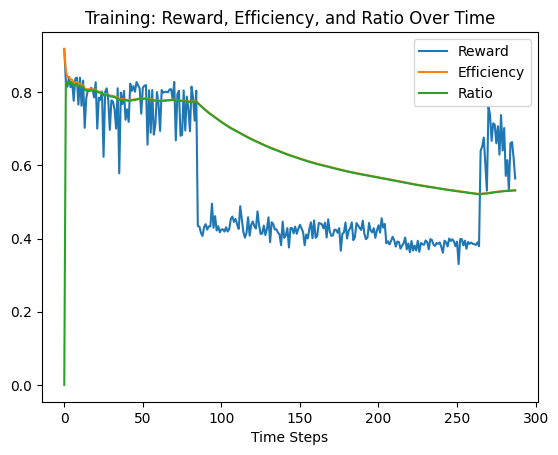

In [76]:
# Optionally, plot reward, efficiency, and ratio
plt.plot(test_env.reward_history, label="Reward")
plt.plot(test_env.efficiency_history, label="Efficiency")
plt.plot(test_env.ratio_history, label="Ratio")
plt.legend()
plt.xlabel("Time Steps")
plt.title("Training: Reward, Efficiency, and Ratio Over Time")
plt.show()